# Mean_Reversion_Analysis
**Author**: Hansen Han  
**Date**: February 4th, 2023  
  

#### Load Data

In [10]:
# Load 1 min BTC data from 2013 to 2019
import pandas as pd

# handle minute data from 2014 to 2019
df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)

# handle hourly data from 2018 to 2023
df2018_2023 = pd.read_csv("BTC_1min_bitfinex/2018_2023.csv", skiprows=[0])
df2018_2023['volume'] = df2018_2023['Volume USD']
df2018_2023['timestamp'] = df2018_2023['date']
df2018_2023.drop(['unix', 'symbol', 'Volume BTC', 'Volume USD', 'date'], axis=1, inplace=True)
df2018_2023

# removed 2013 data
#df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)
#frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]

frames = [df2014, df2015, df2016, df2017, df2018, df2019]

crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

def merge_and_convert_to_hourly(minute_data, hourly_data):
    # Convert timestamp column to datetime format
    minute_data['timestamp'] = pd.to_datetime(minute_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

    # Filter minute_data to only include data from 2014 to 2018
    minute_data = minute_data[minute_data['timestamp'].dt.year < 2019]

    # Round minute_data timestamp to nearest hour
    minute_data['timestamp'] = minute_data['timestamp'].dt.floor('H')

    # Find the latest timestamp in minute_data
    latest_minute_timestamp = minute_data['timestamp'].max()

    # Filter hourly_data to only include data from after the latest timestamp in minute_data
    hourly_data = hourly_data[hourly_data['timestamp'] > latest_minute_timestamp]

    # Combine the two dataframes
    combined_data = pd.concat([minute_data, hourly_data])

    # Drop any duplicates
    combined_data = combined_data.drop_duplicates(subset='timestamp', keep='last')

    # Sort by timestamp
    combined_data = combined_data.sort_values('timestamp')

    # Set the timestamp column as the index
    combined_data = combined_data.set_index('timestamp')

    # Resample to hourly data
    combined_data = combined_data.resample('H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    # Reset the index
    combined_data = combined_data.reset_index()

    return combined_data


crypto_df = merge_and_convert_to_hourly(crypto_df, df2018_2023)
crypto_df



,timestamp,open,high,low,close,volume
0,2014-01-01 00:00:00,739.2800,739.2800,739.2800,739.2800,1.500000e-01
1,2014-01-01 01:00:00,742.9989,742.9989,742.9989,742.9989,3.720000e+00
2,2014-01-01 02:00:00,748.4900,748.8900,748.4900,748.8900,5.740000e+00
3,2014-01-01 03:00:00,740.0000,743.1000,740.0000,740.0000,2.256364e+00
4,2014-01-01 04:00:00,745.3100,745.3100,745.3100,745.3100,1.745600e+00
...,...,...,...,...,...,...
80036,2023-02-17 20:00:00,24523.0000,25023.0000,24523.0000,24834.0000,1.012941e+07
80037,2023-02-17 21:00:00,24833.0000,24841.0000,24426.0000,24495.0000,4.186570e+06
80038,2023-02-17 22:00:00,24479.0000,24745.0000,24057.0000,24692.0000,5.983257e+06
80039,2023-02-17 23:00:00,24687.0000,24745.0000,24525.0000,24582.0000,1.484912e+06


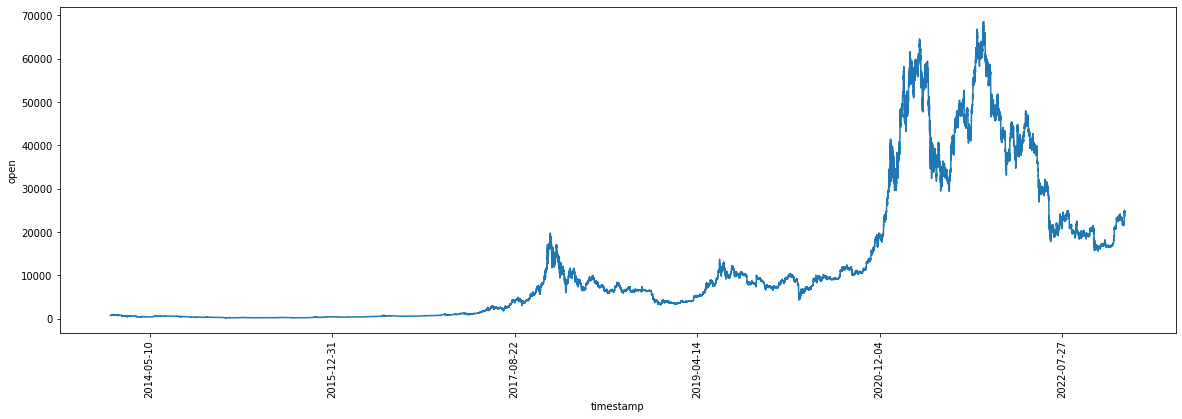

In [11]:
# View the data to make sure it looks right 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('dark_background')

#sns.set_context("talk")
plt.figure(figsize=(20,6))
ax = sns.lineplot(x="timestamp", y="open", 
            data=crypto_df, ci=None)
ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
plt.xticks(rotation="vertical")

plt.show() # looks right...

#### Mean Reversion Backtesting

In [12]:
import numpy as np

def mean_reversion_backtester(sampled_data, 
                            order_sizing, 
                            ma_length, 
                            starting_capital,
                            buy_threshold,
                            take_profit,
                            stop_loss,
                            shorting_allowed,
                            fixed_fee,
                            display_results,
                            record_balance,
                            fee=0
                            ):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma_length: moving average length (in hours)
        starting_capital: how much capital to start with (USD)
        buy_threshold: at what % below the moving average to buy (if 5%, should be 0.05)
        take_profit: at what % gain to sell and take the profit (if 5%, should be 0.05)
        stop_loss: at what % to sell and stop losses (if 5%, should be 0.05)
        shorting_allowed: whether or not to short or sell regularly (true or false)
        fee: the % charged per transaction by the exchange (in %, so 0.01 = 1%)
        record_balance: whether or not to track the balance over the whole period
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """

    # for figuring out how much a fee is
    # we are taking the average of maker and taker fees on coinbase pro starting on 6/5/23
    def find_fee(thirty_day_volume):
        volume_fee_table = {
            10000: 0.005,
            50000: 0.00325,
            100000: 0.002,
            1000000: 0.0015,
            15000000: 0.0013,
            75000000: 0.0011,
            250000000: 0.00075,
            400000000: 0.0004,
        }
        
        for volume, fee in volume_fee_table.items():
            if thirty_day_volume <= volume:
                return fee
        
        # If the volume is greater than the largest key, return the fee for the largest key
        return volume_fee_table[400000000]
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma = sampled_data.price.rolling(ma_length).mean()

    #truncate the data so they all are aligned 
    ma = list(ma[ma_length:])
    sampled_data = sampled_data[ma_length:]
    last_average_higher = "None"

    # set up shorting mechanism
    short_position = None
    short_results = []

    # set up volume data
    thirty_day_volume = 0
    volume_data = []
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        # calculate the fee using the thirty_day_volume
        if not fixed_fee:
            fee = find_fee(thirty_day_volume)

        #get the current price
        current_price = sampled_data.iloc[x]['price']

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if x == 0:
            last_move = "Pass"

        else:
            #begin the trading mechanism

            #if the price dips below a set % from the moving average - BUY
            if last_move != "Buy" and current_price <= ma[x]*(1-buy_threshold):
                if shorting_allowed == True:
                    if short_position == True:
                        # if there is a short position, exit out of it
                        short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                        short_results.append(short_delta)
                        fiat = fiat + (purchase_price*position_size + short_delta)*(1 - fee) # sell the position and the short
                        position_size = 0 # set the position to zero
                    short_position = False 

                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat*(1 - fee))/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                last_move = "Buy"
                trades = trades + 1
                purchase_price = current_price

            #if the take profit or stop loss threshold is crossed - SELL
            elif last_move == "Buy" and (current_price >= ma[x]*(1+take_profit) or current_price <=ma[x]*(1-stop_loss)):
                fiat = fiat + position_size*current_price*(1 - fee)
                position_size = 0

                if shorting_allowed == True:
                    position_size = (order_sizing*fiat*(1 - fee))/current_price
                    fiat = fiat - position_size*current_price
                    last_move = "Short-Sell"
                    short_position = True
                    purchase_price = current_price
                else:
                    last_move = "Sell"
                    # reset the purchase price
                    purchase_price = 0

                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                

            else:
                pass
                #moves.append("Pass")
        
        if shorting_allowed == True:
            #record the portfolio information
            if short_position == False or short_position == None:
                if record_balance == True:
                    portfolio_balance.append(position_size*current_price + fiat)
            if short_position == True:
                short_delta = (purchase_price*position_size - current_price*position_size)
                if record_balance == True:
                    portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
        else:
            #record the portfolio information
            if record_balance == True:
                portfolio_balance.append(position_size*current_price + fiat)
            
        if record_balance == True:
            baseline_balance.append(baseline_position_size*current_price)

        # go through the volume data
        thirty_day_volume = 0 # re-calculate the current thirty_day_volume
        new_volume_data = []
        for volume_data_entry in volume_data:
            if volume_data_entry[0] < 720: # 720 hours in thirty days
                thirty_day_volume = thirty_day_volume + volume_data_entry[1]
                new_volume_data.append([volume_data_entry[0] + 1, volume_data_entry[1]])
        
        volume_data = new_volume_data
        
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1  
    final_return_rate = ((position_size*current_price + fiat)/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))


    if display_results == True and record_balance == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Mean Reversion'] = portfolio_balance
        plot_data['Baseline'] = baseline_balance
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    else:
        plot_data = "Could not generate plot_data: display_results and/or record_balance was set to False."

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    # if there are NAs in the hit rate, ignore it.
    if 'N/A' not in backtest_results['quarter_hit_rates']:
        clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
        graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
        #Drawing a horizontal line at 0.5
        graph.axhline(0.5)
        plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["Mean Reversion" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

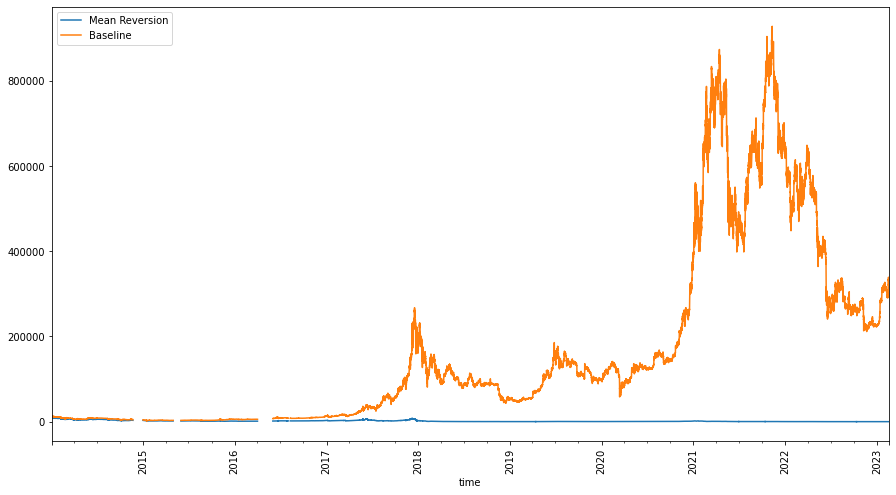

Hit Rate: 0.0
Mean Reversion Return Rate: -98.87 %
Buy & Hold Return Rate: 3224.86 %
Median Return per Quarter: 0.82 %


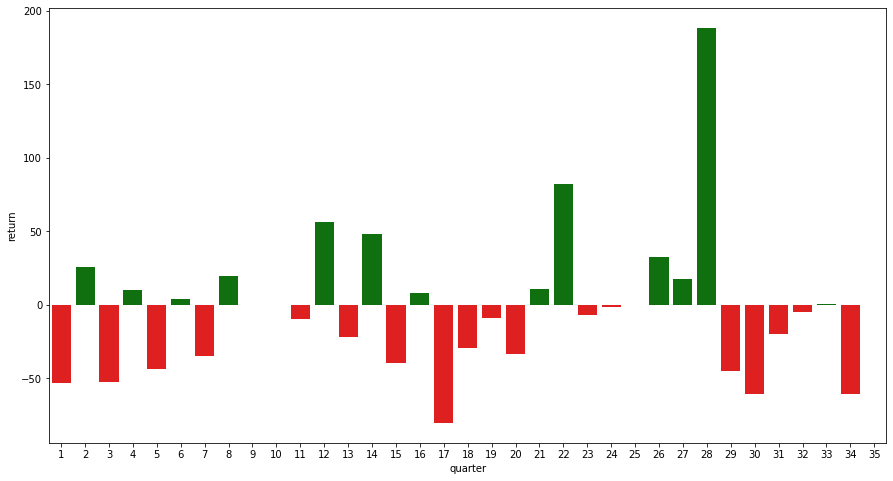

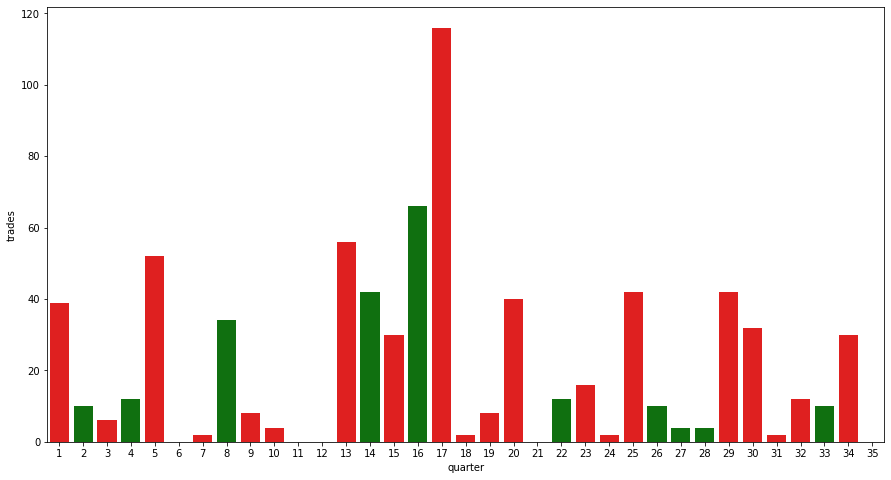

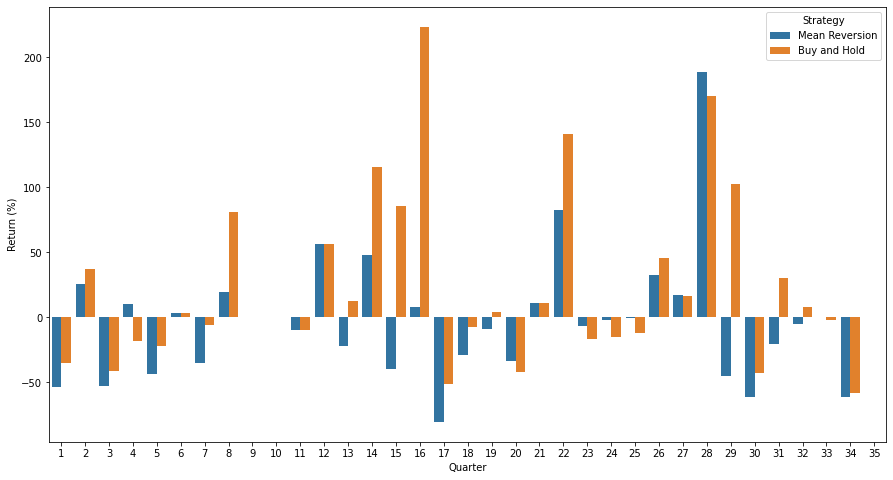

In [13]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

backtest_results = mean_reversion_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma_length = 48,
            buy_threshold = 0.05,
            take_profit=0.1,
            stop_loss=0.1, 
            starting_capital = 10000,
            shorting_allowed=True,
            fixed_fee=False,
            fee = 0.005,
            display_results=True,
            record_balance=True
        )

#Interpret backtest results
import statistics
print("Hit Rate:", backtest_results['hit_rate'])
print("Mean Reversion Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")
print("Median Return per Quarter:", round(statistics.median(backtest_results['quarter_return_rates']*100), 2), "%")

plot_quarterly_data(backtest_results)

### What are the optimal parameters for a mean reversion strategy? 

In [135]:
from tqdm import trange # for tracking progress
import random

def run_multiple_backtests(shorting_allowed, num_runs, fixed_fee):
    """
    shorting_allowed: bool
    num_runs: int
    """

    # test lots of combinations
    ma_combinations = []
    buy_thresholds = []
    stop_loss_thresholds = []
    take_profit_thresholds = []
    median_return_rate_results = []
    stdev_return_rate_results = []
    profitable_quarters_results = [] 
    cumulative_return_results = []
    cumulative_baseline_return_results = []
    sharpe_ratios = []
    total_trades_results = []
    mean_trades_results = []

    # run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
    for x in trange(num_runs):
        stop_loss = round(random.randrange(0, 100),2)/100
        buy_threshold = round(random.randrange(0, 100),2)/100
        take_profit = round(random.randrange(0, 100),2)/100
        ma_length = random.randrange(0, round(2191/2))

        ma_combinations.append(ma_length)
        buy_thresholds.append(buy_threshold)
        stop_loss_thresholds.append(stop_loss)
        take_profit_thresholds.append(take_profit)

        backtest_results = mean_reversion_backtester(
                sampled_data = crypto_df,
                order_sizing = 1,
                ma_length = ma_length,
                buy_threshold = buy_threshold,
                take_profit = take_profit, 
                stop_loss = stop_loss,
                starting_capital = 10000,
                shorting_allowed=shorting_allowed,
                fixed_fee=fixed_fee,
                record_balance=False,
                fee = 0,
                display_results = False
            )
        
        median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
        stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
        profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
        cumulative_return = backtest_results['final_return_rate']
        cumulative_baseline_return = backtest_results["baseline_return_rate"]
        sharpe_ratio = backtest_results["sharpe_ratio"]
        total_trades = sum([x for x in backtest_results['quarter_trades']])
        mean_trades_per_quarter = total_trades/len(backtest_results['quarter_trades'])

        median_return_rate_results.append(median_return_rate)
        stdev_return_rate_results.append(stdev_return_rate)
        profitable_quarters_results.append(profitable_quarters)
        cumulative_return_results.append(cumulative_return)
        cumulative_baseline_return_results.append(cumulative_baseline_return)
        sharpe_ratios.append(sharpe_ratio)
        total_trades_results.append(total_trades)
        mean_trades_results.append(mean_trades_per_quarter)

    # compile results into a table for exploration
    optimization_results = pd.DataFrame()
    optimization_results["ma"] = ma_combinations
    optimization_results["buy_threshold"] = buy_thresholds
    optimization_results["take_profit_threshold"] = take_profit_thresholds
    optimization_results["stop_loss_threshold"] = stop_loss_thresholds
    optimization_results["median_return_rate"] = median_return_rate_results
    optimization_results["stdev_return_rate"] = stdev_return_rate_results
    optimization_results["cumulative_return"] = cumulative_return_results
    optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
    optimization_results["profitable_quarters"] = profitable_quarters_results
    optimization_results["sharpe_ratio"] = sharpe_ratios
    optimization_results["total_trades"] = total_trades_results
    optimization_results["mean_trades_per_quarter"] = mean_trades_results

    #optimization_results.head()
    return optimization_results


100%|██████████| 100/100 [27:27<00:00, 16.47s/it]


In [ ]:
# Run all the combinations we want to look at 
combo_1_results = run_multiple_backtests(shorting_allowed=True, num_runs=100, fixed_fee=True)
combo_1_results.to_csv("run_output/mean_reversion_shorting_no_fee.csv")

combo_2_results = run_multiple_backtests(shorting_allowed=True, num_runs=100, fixed_fee=False)
combo_2_results.to_csv("run_output/mean_reversion_shorting_with_fee.csv")

combo_3_results = run_multiple_backtests(shorting_allowed=False, num_runs=100, fixed_fee=True)
combo_3_results.to_csv("run_output/mean_reversion_no_shorting_no_fee.csv")

combo_4_results = run_multiple_backtests(shorting_allowed=False, num_runs=100, fixed_fee=False)
combo_4_results.to_csv("run_output/mean_reversion_no_shorting_with_fee.csv")